# Capstone Project - Scores for shoe features and ratings

__Recommendation for running shoes based on:__
- [Similar shoe features](#shortcut1)
- [User's profile](#shortcut2)

In [1]:
import pandas as pd
import numpy as np
import pickle
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
pd.set_option('display.max_columns', 50)

from collections import defaultdict, Counter
import string
import re
import codecs
from tqdm import tqdm

from sklearn.metrics.pairwise import cosine_similarity
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, MultiLabelBinarizer, MinMaxScaler, StandardScaler

### Reading in cleaned shoe data

In [2]:
df = pickle.load(open('shoe_data.pkl', 'rb'))
df

,name,brand,core_score,user_review_count,expert_review_count,user_rating,expert_rating,user_5star,user_4star,user_3star,user_2star,user_1star,discontinued,terrain,arch_support,use,waterproof,water_repellent,maximalist,minimalist,triathlon,price,weight,toe_drop,heel_height,forefoot_height,width,good_summary,bad_summary,summary,info,size_fit,outsole,midsole,upper,weight_m,weight_w,toe_drop_m,toe_drop_w,heel_height_m,heel_height_w,forefoot_height_m,forefoot_height_w,width_m,width_w,zero_drop_m,zero_drop_w,low_drop_m,low_drop_w
0,Nike Air Zoom Pegasus 35,Nike,94,2249,27,4.4,94.0,71,14,6,4,5,1,1,Neutral,1,0,0,0,0,0,230,Men: 286g;Women: 255g;,Men: 10mm;Women: 10mm;,Men: 29mm;Women: 29mm;,Men: 19mm;Women: 19mm;,"Men: Narrow, Standard, Wide, Extra wide;Women:...",Many people liked the aesthetics of the Nike A...,A tester complained that the upper unit of the...,Many people liked the Nike Air Zoom Pegasus 35...,The Nike Air Zoom Pegasus 35 is a running shoe...,The Nike Air Zoom Pegasus 35 has a standard ru...,The outsole unit of the Nike Air Zoom Pegasus ...,Zoom Air is a cassette that contains compresse...,The upper unit of the Nike Air Zoom Pegasus 35...,286,255,10,10,29,29,19,19,"Narrow, Standard, Wide, Extra wide","Standard, Wide",0,0,0,0
1,Brooks Ghost 11,Brooks,94,4358,17,4.5,91.0,78,9,5,3,5,1,1,Neutral,1,0,0,0,0,0,230,Men: 309g;Women: 269g;,Men: 12mm;Women: 12mm;,Men: 29mm;Women: 29mm;,Men: 17mm;Women: 17mm;,"Men: Narrow, Standard, Wide, Extra wide;Women:...",The Brooks Ghost 11 had a nice cushion that en...,One reviewer attributed the shoe’s bulky and u...,Many users have found themselves considering b...,The latest iteration of the Brooks Ghost is a ...,The Brooks Ghost 11 guarantees a fit that is t...,Two types of rubber make up the outsole of the...,The BioMoGo DNA from Brooks is a tried-and-tes...,The engineered mesh upper of the Brooks Ghost ...,309,269,12,12,29,29,17,17,"Narrow, Standard, Wide, Extra wide","Narrow, Standard, Wide",0,0,0,0
2,Asics Gel Kayano 25,Asics,95,4091,8,4.6,92.0,79,11,3,2,5,1,1,Stability,1,0,0,0,0,0,310,Men: 336g;Women: 278g;,Men: 10mm;Women: 13mm;,Men: 22mm;Women: 24mm;,Men: 12mm;Women: 11mm;,"Men: Narrow, Standard, Wide, Extra wide;Women:...",The Kayano 25 is very comfortable to wear even...,The shoe is slightly expensive.;A couple of we...,The overwhelming number of positive feedback h...,The Gel Kayano series from Asics brings out th...,Runners will find the Asics Gel Kayano 25 as t...,Compared to the regular Asics High Abrasion Ru...,The forefoot and rearfoot areas of the midsole...,The Gel Kayano 25 welcomes the use of Jacquard...,336,278,10,13,22,24,12,11,"Narrow, Standard, Wide, Extra wide","Narrow, Standard, Wide",0,0,0,0
3,Asics Gel Venture 6,Asics,94,4158,1,4.5,90.0,74,14,5,3,4,1,0,Neutral,1,0,0,0,0,0,140,Men: 318g;Women: 255g;,Men: 10mm;Women: 10mm;,Men: 20mm;Women: 20mm;,Men: 10mm;Women: 10mm;,"Men: Standard, Wide, Extra wide;Women: Narrow,...",Most customers appreciated the strong build of...,A couple of wearers noticed that the gel cushi...,The Asics Gel Venture 6 is a versatile running...,"The Asics Gel Venture 6 has been redesigned, f...",The Asics Gel Venture 6 fits true to size. It ...,The shoe houses technologies specific to trail...,The midsole of this Asics running shoes has th...,The synthetic mesh material covers the upper s...,318,255,10,10,20,20,10,10,"Standard, Wide, Extra wide","Narrow, Standard, Wide, Extra wide",0,0,0,0
4,Hoka One One Bondi 6,Hoka One One,91,794,7,4.2,92.0,64,14,9,7,6,0,1,Neutral,1,0,0,1,0,0,290,Men: 309g;Women: 244g;,Men: 4mm;Women: 4mm;,Men: 36mm;Women: 36mm;,Men: 32mm;Women: 32mm;,"Men: Narrow, Standard, Wide;Women: Narrow, Sta...",People mostly liked the cushioning capacity of...,Several consumers felt that the Hoka One One B...,People were mostly happy with the Hoka One One...,Hoka One One is a brand that prides itself in ...,The Hoka One One Bondi 6 was created to be tru...,The rubber compound that’s used for the outsol...,A Soft EVA Midsole serve

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 848 entries, 0 to 847
Data columns (total 49 columns):
name                   848 non-null object
brand                  848 non-null object
core_score             848 non-null int64
user_review_count      848 non-null int64
expert_review_count    848 non-null int64
user_rating            848 non-null float64
expert_rating          848 non-null float64
user_5star             848 non-null int64
user_4star             848 non-null int64
user_3star             848 non-null int64
user_2star             848 non-null int64
user_1star             848 non-null int64
discontinued           848 non-null int64
terrain                848 non-null int64
arch_support           848 non-null object
use                    848 non-null int64
waterproof             848 non-null int64
water_repellent        848 non-null int64
maximalist             848 non-null int64
minimalist             848 non-null int64
triathlon              848 non-null int64
price 

### Create similarity matrices

#### Create similarity matrix for shoe width

In [4]:
# Convert each width string into a list.
df['width_m'] = df['width_m'].map(lambda x: x.split(", "))
df['width_w'] = df['width_w'].map(lambda x: x.split(", "))

In [5]:
# unique_widths = ['Narrow', 'Standard', 'Wide', 'Extra wide']

In [6]:
# MultiLabelBinarize width matrices
mlb = MultiLabelBinarizer()

width_m_matrix = pd.DataFrame(mlb.fit_transform(df['width_m']),columns=mlb.classes_, index=df.index)
width_w_matrix = pd.DataFrame(mlb.fit_transform(df['width_w']),columns=mlb.classes_, index=df.index)

In [7]:
# Width of men's shoes
print(width_m_matrix.shape)
width_m_matrix.head(5)

(848, 4)


,Extra wide,Narrow,Standard,Wide
0,1,1,1,1
1,1,1,1,1
2,1,1,1,1
3,1,0,1,1
4,0,1,1,1


In [8]:
# Width of women's shoes
print(width_w_matrix.shape)
width_w_matrix.head(5)

(848, 4)


,Extra wide,Narrow,Standard,Wide
0,0,0,1,1
1,0,1,1,1
2,0,1,1,1
3,1,1,1,1
4,0,1,1,1


#### Create similarity matrices for other shoe features

In [9]:
# Function to one-hot encode
def one_hot_encode(series_items, unique_set):
    dummies = np.zeros((df.shape[0], len(unique_set)))
    for row, shoe_items in enumerate(series_items):
        for col, item in enumerate(unique_set):
#             if type(shoe_items) == list:
            if item in shoe_items:
                dummies[row, col] = 1
    # convert to dataframe
    dummies_matrix = pd.DataFrame(dummies, columns=unique_set)
    return dummies_matrix

In [10]:
# Function to create the cosine similarity matrix
def create_cos_sim(num_shoes, matrix):
    # create empty matrix
    cos_sim = np.zeros((num_shoes, num_shoes))
    # calculate cosine similarity for each pair of shoes
    for r in tqdm(range(num_shoes)):
        for c in range(num_shoes):
            x = matrix.iloc[r,:].values.reshape(1, -1)
            y = matrix.iloc[c,:].values.reshape(1, -1)
            cos_sim[r,c] = cosine_similarity(x,y)
    # convert into dataframe
    cos_sim_df = pd.DataFrame(cos_sim)
    return cos_sim_df

#### Create similarity matrix for shoe brand

In [11]:
# Get unique list of brands from all shoes
brand_list = list(df.brand.unique())
print(brand_list)
# one-hot-encode brand matrix
brand_matrix = one_hot_encode(df.brand, brand_list)
brand_matrix.shape

['Nike', 'Brooks', 'Asics', 'Hoka One One', 'Merrell', 'Adidas', 'Altra', 'Mizuno', 'New Balance', 'Saucony', 'Salomon', 'On', 'Skechers', 'Under Armour', 'Reebok', 'Topo Athletic', 'La Sportiva', 'Inov-8', 'Vibram FiveFingers', '361 Degrees', 'Vivobarefoot', 'Zoot', 'Newton', 'The North Face', 'Scott', 'Salming', 'Puma']


(848, 27)

#### Create similarity matrix for shoe terrain

In [12]:
terrain_matrix = df.filter(items=['terrain'])
terrain_matrix.shape

(848, 1)

#### Create similarity matrix for shoe arch support

In [13]:
# get unique list of arch support from all shoes
arch_list = list(df.arch_support.unique())
print(arch_list)
# one-hot-encode arch support matrix
arch_matrix = one_hot_encode(df.arch_support, arch_list)
arch_matrix.shape

['Neutral', 'Stability', 'Motion control']


(848, 3)

#### Create similarity matrix for shoe use

In [14]:
use_matrix = df.filter(items=['use'])
use_matrix.shape

(848, 1)

#### Create similarity matrix for zero drop shoes

In [15]:
zero_drop_m_matrix = df.filter(items=['zero_drop_m'])
zero_drop_m_matrix.shape

(848, 1)

In [16]:
zero_drop_w_matrix = df.filter(items=['zero_drop_w'])
zero_drop_w_matrix.shape

(848, 1)

#### Create similarity matrix for low drop shoes

In [17]:
low_drop_m_matrix = df.filter(items=['low_drop_m'])
low_drop_m_matrix.shape

(848, 1)

In [18]:
low_drop_w_matrix = df.filter(items=['low_drop_w'])
low_drop_w_matrix.shape

(848, 1)

#### Create similarity matrix for waterproof shoes

In [19]:
waterproof_matrix = df.filter(items=['waterproof'])
waterproof_matrix.shape

(848, 1)

#### Create similarity matrix for water repellent shoes

In [20]:
water_repellent_matrix = df.filter(items=['water_repellent'])
water_repellent_matrix.shape

(848, 1)

#### Create similarity matrix for maximalist shoes

In [21]:
maximalist_matrix = df.filter(items=['maximalist'])
maximalist_matrix.shape

(848, 1)

#### Create similarity matrix for minimalist shoes

In [22]:
minimalist_matrix = df.filter(items=['minimalist'])
minimalist_matrix.shape

(848, 1)

#### Create similarity matrix for triathlon shoes

In [23]:
triathlon_matrix = df.filter(items=['triathlon'])
triathlon_matrix.shape

(848, 1)

#### Normalize shoe features

Normalize shoe features from 0 to 1.

In [24]:
mm = MinMaxScaler()

# Normalise price
price = df.price.values.reshape(-1,1)
price_sc = pd.Series(mm.fit_transform(price).ravel())

# Normalise weight
weight_m = df.weight_m.values.reshape(-1,1)
weight_m_sc = pd.Series(mm.fit_transform(weight_m).ravel())
weight_w = df.weight_w.values.reshape(-1,1)
weight_w_sc = pd.Series(mm.fit_transform(weight_w).ravel())

# Normalise heel-to-toe drop
toe_drop_m = df.toe_drop_m.values.reshape(-1,1)
toe_drop_m_sc = pd.Series(mm.fit_transform(toe_drop_m).ravel())
toe_drop_w = df.toe_drop_w.values.reshape(-1,1)
toe_drop_w_sc = pd.Series(mm.fit_transform(toe_drop_w).ravel())

# Normalise heel height
heel_height_m = df.heel_height_m.values.reshape(-1,1)
heel_height_m_sc = pd.Series(mm.fit_transform(heel_height_m).ravel())
heel_height_w = df.heel_height_w.values.reshape(-1,1)
heel_height_w_sc = pd.Series(mm.fit_transform(heel_height_w).ravel())

# Normalise forefoot height
forefoot_height_m = df.forefoot_height_m.values.reshape(-1,1)
forefoot_height_m_sc = pd.Series(mm.fit_transform(forefoot_height_m).ravel())
forefoot_height_w = df.forefoot_height_w.values.reshape(-1,1)
forefoot_height_w_sc = pd.Series(mm.fit_transform(forefoot_height_w).ravel())

#### Create cosine similarity matrix

In [25]:
# Join matrices for Men's shoes
comb_m_matrix = pd.concat([
#     brand_matrix,
#     width_m_matrix,
    terrain_matrix,
    arch_matrix,
    use_matrix,
#     zero_drop_m_matrix,
#     low_drop_m_matrix,
    waterproof_matrix,
    water_repellent_matrix,
#     maximalist_matrix,
#     minimalist_matrix,
    triathlon_matrix,
    price_sc,
    weight_m_sc,
#     toe_drop_m_sc,
    heel_height_m_sc,
    forefoot_height_m_sc
], axis=1)

comb_m_matrix = comb_m_matrix.rename(columns={
    0: "Price",
    1: "Weight",
    2: "Toe drop",
    3: "Heel height",
    4: "Forefoot height"})

comb_m_matrix

,terrain,Neutral,Stability,Motion control,use,waterproof,water_repellent,triathlon,Price,Weight,Toe drop,Heel height
0,1,1.0,0.0,0.0,1,0,0,0,0.305556,0.453659,0.710526,0.484848
1,1,1.0,0.0,0.0,1,0,0,0,0.305556,0.509756,0.710526,0.424242
2,1,0.0,1.0,0.0,1,0,0,0,0.527778,0.575610,0.526316,0.272727
3,0,1.0,0.0,0.0,1,0,0,0,0.055556,0.531707,0.473684,0.212121
4,1,1.0,0.0,0.0,1,0,0,0,0.472222,0.509756,0.894737,0.878788
5,0,1.0,0.0,0.0,0,0,0,0,0.194444,0.317073,0.236842,0.242424
6,1,1.0,0.0,0.0,1,0,0,0,0.305556,0.446341,0.684211,0.454545
7,1,0.0,0.0,1.0,1,0,0,0,0.305556,0.448780,0.710526,0.424242
8,1,1.0,0.0,0.0,1,0,0,0,0.611111,0.446341,0.684211,0.454545
9,1,1.0,0.0,0.0,1,0,0,0,0.472222,0.512195,0.552632,0.303030


In [26]:
# Join matrices for Women's shoes
comb_w_matrix = pd.concat([
#     brand_matrix,
#     width_w_matrix,
    terrain_matrix,
    arch_matrix,
    use_matrix,
#     zero_drop_w_matrix,
#     low_drop_w_matrix,
    waterproof_matrix,
    water_repellent_matrix,
#     maximalist_matrix,
#     minimalist_matrix,
    triathlon_matrix,
    price_sc,
    weight_w_sc,
#     toe_drop_w_sc,
    heel_height_w_sc,
    forefoot_height_w_sc
], axis=1)

comb_w_matrix = comb_w_matrix.rename(columns={
    0: "Price",
    1: "Weight",
    2: "Toe drop",
    3: "Heel height",
    4: "Forefoot height"})

comb_w_matrix

,terrain,Neutral,Stability,Motion control,use,waterproof,water_repellent,triathlon,Price,Weight,Toe drop,Heel height
0,1,1.0,0.0,0.0,1,0,0,0,0.305556,0.406977,0.702703,0.514286
1,1,1.0,0.0,0.0,1,0,0,0,0.305556,0.439535,0.702703,0.457143
2,1,0.0,1.0,0.0,1,0,0,0,0.527778,0.460465,0.567568,0.285714
3,0,1.0,0.0,0.0,1,0,0,0,0.055556,0.406977,0.459459,0.257143
4,1,1.0,0.0,0.0,1,0,0,0,0.472222,0.381395,0.891892,0.885714
5,0,1.0,0.0,0.0,0,0,0,0,0.194444,0.209302,0.216216,0.285714
6,1,1.0,0.0,0.0,1,0,0,0,0.305556,0.341860,0.702703,0.514286
7,1,0.0,0.0,1.0,1,0,0,0,0.305556,0.381395,0.702703,0.457143
8,1,1.0,0.0,0.0,1,0,0,0,0.611111,0.269767,0.675676,0.485714
9,1,1.0,0.0,0.0,1,0,0,0,0.472222,0.406977,0.594595,0.314286


In [27]:
# create cosine similarity matrix for men's shoes.
comb_m_sim = create_cos_sim(df.shape[0], comb_m_matrix)
comb_m_sim

100%|██████████| 848/848 [05:31<00:00,  2.63it/s]


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,...,823,824,825,826,827,828,829,830,831,832,833,834,835,836,837,838,839,840,841,842,843,844,845,846,847
0,1.000000,0.999156,0.732149,0.839703,0.981959,0.661857,0.999832,0.750142,0.988845,0.988934,0.995844,0.995850,0.995710,0.852569,0.861334,0.991107,0.987415,0.992976,0.857022,0.857920,0.858199,0.999624,0.862011,0.855382,0.999273,...,0.513955,0.866124,0.866770,0.739246,0.550183,0.557446,0.458466,0.859742,0.743444,0.852933,0.993881,0.833965,0.998267,0.864057,0.848630,0.751838,0.859888,0.996800,0.990266,0.866514,0.849118,0.840882,0.847789,0.994929,0.824596
1,0.999156,1.000000,0.736185,0.845096,0.976628,0.663318,0.999335,0.750106,0.988367,0.991681,0.994223,0.994197,0.991585,0.849952,0.859000,0.993364,0.987357,0.992567,0.852334,0.851786,0.853152,0.998742,0.856729,0.855656,0.997898,...,0.511664,0.866555,0.864376,0.739129,0.554392,0.554983,0.459125,0.854093,0.745893,0.848900,0.991193,0.832592,0.997179,0.860771,0.850162,0.748496,0.858559,0.996264,0.991255,0.869641,0.852601,0.832050,0.838917,0.992548,0.821940
2,0.732149,0.736185,1.000000,0.516283,0.726957,0.213595,0.732099,0.732731,0.746864,0.743948,0.741960,0.741825,0.726809,0.520965,0.558232,0.730050,0.750675,0.742905,0.561181,0.538022,0.559936,0.727452,0.533514,0.522572,0.730802,...,0.744300,0.564484,0.553342,0.987056,0.863655,0.843658,0.811945,0.530556,0.514286,0.558819,0.721953,0.486509,0.738012,0.548012,0.586020,0.965351,0.535087,0.727935,0.746606,0.647079,0.526495,0.520760,0.512229,0.710508,0.472862
3,0.839703,0.845096,0.516283,1.000000,0.808950,0.750509,0.840106,0.527516,0.817087,0.833293,0.828294,0.828131,0.824086,0.569426,0.586414,0.840396,0.818208,0.823258,0.582552,0.577989,0.926720,0.841792,0.590347,0.590718,0.837524,...,0.517376,0.970068,0.960312,0.512049,0.586088,0.204050,0.095846,0.594923,0.824037,0.570656,0.827970,0.555527,0.838073,0.952720,0.931524,0.528313,0.586045,0.836182,0.834569,0.732242,0.993774,0.906939,0.556446,0.836517,0.539933
4,0.981959,0.976628,0.726957,0.808950,1.000000,0.666799,0.978763,0.753902,0.977078,0.958106,0.991345,0.991350,0.993430,0.843432,0.873099,0.953058,0.979377,0.975715,0.885200,0.879109,0.893734,0.979898,0.878858,0.838580,0.985468,...,0.565812,0.875821,0.879764,0.735982,0.575468,0.589966,0.452689,0.880841,0.754146,0.873121,0.975095,0.804750,0.989480,0.883998,0.865252,0.770315,0.853918,0.969749,0.976123,0.827638,0.822963,0.883245,0.867376,0.976064,0.794310
5,0.661857,0.663318,0.213595,0.750509,0.666799,1.000000,0.660685,0.211730,0.664281,0.661237,0.668847,0.668698,0.662537,0.747806,0.757337,0.654398,0.668704,0.661868,0.747939,0.756491,0.754384,0.659417,0.753837,0.756092,0.660874,...,0.251386,0.768321,0.760549,0.189876,0.242626,0.213762,0.112505,0.749511,0.672552,0.750393,0.657811,0.729371,0.669927,0.752436,0.763062,0.225136,0.751572,0.656921,0.674808,0.573544,0.756455,0.728438,0.738354,0.647234,0.718986
6,0.999832,0.999335,0.732099,0.840106,0.978763,0.660685,1.000000,0.748128,0.989210,0.990837,0.994822,0.994831,0.994349,0.852201,0.859178,0.993258,0.987428,0.993641,0.853263,0.854928,0.853430,0.999420,0.858684,0.855196,0.998534,...,0.509070,0.863480,0.863853,0.738183,0.547891,0.553358,0.459109,0.855674,0.742098,0.850512,0.994438,0.835081,0.997379,0.859920,0.846677,0.748384,0.858815,0.997887,0.990661,0.869431,0.849765,0.834625,0.844850,0.994122,0.825971
7,0.750142,0.750106,0.732731,0.527516,0.753902,0.211730,0.748128,1.000000,0.745749,0.736589,0.755882,0.755825,0.750605,0.536669,0.570511,0.731015,0.748400,0.744915,0.582134,0.561382,0.587278,0.748707,0.566229,0.537914,0.753380,...,0.507586,0.579226,0.576249,0.738557,0.548666,0.553254,0.458415,0.570103,0.501902,0.568062,0.734966,0.504792,0.754536,0.583121,0.575914,0.746972,0.553450,0.738140,0.743988,0.635930,0.532592,0.573909,0.545738,0.744987,0.492614
8,0.988845,0.988367,0.746864,0.817087,0.977078,0.664281,0.989210,0.745749,1.000000,0.993141,0.994770,0.994788,0.986878,0.852141,0.870703,0.983632,0.999432,0.999119,0.866933,0.857367,

In [28]:
# create cosine similarity matrix for women's shoes.
comb_w_sim = create_cos_sim(df.shape[0], comb_w_matrix)
comb_w_sim

100%|██████████| 848/848 [05:22<00:00,  2.66it/s]


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,...,823,824,825,826,827,828,829,830,831,832,833,834,835,836,837,838,839,840,841,842,843,844,845,846,847
0,1.000000,0.999466,0.731780,0.841470,0.982764,0.654711,0.999488,0.748249,0.986164,0.990137,0.995907,0.995910,0.995262,0.853392,0.859707,0.991373,0.953614,0.992304,0.856394,0.856677,0.858296,0.999622,0.860306,0.854193,0.999082,...,0.512229,0.866412,0.866408,0.736996,0.548060,0.552368,0.453410,0.860922,0.741448,0.855106,0.993017,0.835401,0.996787,0.863065,0.848767,0.748599,0.860624,0.994885,0.991526,0.861226,0.847927,0.842680,0.853868,0.994553,0.824677
1,0.999466,1.000000,0.734001,0.843951,0.977604,0.652671,0.998394,0.747410,0.984943,0.992396,0.994578,0.994466,0.991693,0.851577,0.857219,0.993230,0.960489,0.991915,0.852200,0.851011,0.853170,0.999071,0.855192,0.853783,0.997944,...,0.508815,0.864635,0.864565,0.736226,0.550148,0.548544,0.452587,0.856426,0.742080,0.852379,0.990694,0.834794,0.996359,0.859362,0.848290,0.744334,0.860711,0.993872,0.991548,0.864229,0.849177,0.834619,0.847542,0.992842,0.824096
2,0.731780,0.734001,1.000000,0.502529,0.725335,0.185811,0.728635,0.731598,0.739544,0.740493,0.741762,0.741217,0.725517,0.523699,0.555711,0.726123,0.735801,0.740480,0.562506,0.535202,0.557932,0.727166,0.530246,0.517152,0.730387,...,0.742276,0.553403,0.556129,0.988901,0.858136,0.842159,0.806576,0.535306,0.504786,0.565745,0.717870,0.489460,0.738192,0.545089,0.576836,0.965590,0.540333,0.720827,0.740306,0.639128,0.513623,0.522325,0.524164,0.711561,0.477280
3,0.841470,0.843951,0.502529,1.000000,0.810286,0.737524,0.838118,0.519362,0.810608,0.830605,0.829680,0.829076,0.826630,0.572251,0.581230,0.839319,0.801683,0.822684,0.581647,0.577074,0.932703,0.843733,0.587239,0.583799,0.838496,...,0.513281,0.969799,0.966932,0.504509,0.576921,0.186947,0.079701,0.600519,0.819776,0.577470,0.829924,0.558786,0.840445,0.956517,0.930063,0.518361,0.589704,0.832623,0.831306,0.726661,0.993162,0.918645,0.573153,0.839665,0.546312
4,0.982764,0.977604,0.725335,0.810286,1.000000,0.661047,0.983179,0.752056,0.977643,0.960373,0.991495,0.991704,0.993972,0.848451,0.873441,0.954617,0.909910,0.977551,0.885350,0.878129,0.891050,0.980654,0.877784,0.839693,0.986607,...,0.558320,0.875428,0.877733,0.735112,0.568433,0.585333,0.450968,0.879582,0.749485,0.875638,0.975263,0.812622,0.986042,0.882276,0.864008,0.765690,0.853397,0.970553,0.975477,0.821541,0.824221,0.881895,0.874673,0.977882,0.797869
5,0.654711,0.652671,0.185811,0.737524,0.661047,1.000000,0.652501,0.193137,0.652493,0.647254,0.661397,0.661030,0.658307,0.751770,0.753691,0.644753,0.614623,0.654217,0.746792,0.758501,0.751040,0.652322,0.753123,0.751448,0.653167,...,0.237969,0.757553,0.756685,0.173192,0.222333,0.198159,0.101447,0.751045,0.659036,0.753831,0.653771,0.735040,0.662051,0.746380,0.751676,0.205787,0.752846,0.647449,0.662814,0.560392,0.746111,0.731386,0.754287,0.642069,0.728697
6,0.999488,0.998394,0.728635,0.838118,0.983179,0.652501,1.000000,0.746553,0.987870,0.989414,0.995219,0.995432,0.996369,0.854842,0.859872,0.990332,0.952355,0.993033,0.856538,0.857315,0.856376,0.999082,0.860831,0.853714,0.999188,...,0.507210,0.864285,0.863748,0.736294,0.540618,0.551172,0.453172,0.859087,0.737241,0.854392,0.993803,0.837859,0.994197,0.861810,0.845580,0.747551,0.859696,0.996296,0.989100,0.860357,0.847034,0.841945,0.855560,0.995531,0.827896
7,0.748249,0.747410,0.731598,0.519362,0.752056,0.193137,0.746553,1.000000,0.739416,0.735299,0.754005,0.753752,0.748356,0.536590,0.566445,0.728081,0.711024,0.741761,0.580179,0.558404,0.584724,0.746858,0.562360,0.533157,0.751107,...,0.504579,0.571737,0.575768,0.735997,0.543795,0.547752,0.452618,0.571467,0.495170,0.570511,0.732002,0.505044,0.752504,0.579075,0.569445,0.743781,0.551527,0.732746,0.740742,0.627261,0.523597,0.573938,0.552742,0.743249,0.490148
8,0.986164,0.984943,0.739544,0.810608,0.977643,0.652493,0.987870,0.739416,1.000000,0.991407,0.992055,0.992524,0.987233,0.854279,0.868369,0.980243,0.967679,0.998658,0.865506,0.856350,

In [51]:
# Save to pickle
pickle.dump(comb_m_sim, open('comb_m_sim.pkl', 'wb'))
pickle.dump(comb_w_sim, open('comb_w_sim.pkl', 'wb'))

# pickle.dump(brand_matrix, open('brand_matrix.pkl', 'wb'))
# pickle.dump(terrain_matrix, open('terrain_matrix.pkl', 'wb'))
# pickle.dump(arch_matrix, open('arch_matrix.pkl', 'wb'))
# pickle.dump(use_matrix, open('use_matrix.pkl', 'wb'))

<a id='shortcut1'></a>
### Recommending shoes based on similarity of shoe features

#### Men's Shoes

In [83]:
df.index[df['name'] == "Brooks Glycerin 17"]

Int64Index([11], dtype='int64')

In [86]:
comb_m_sim = pickle.load(open('comb_m_sim.pkl', 'rb'))
test_m = comb_m_sim[11].sort_values(ascending=False).head(6)
test_m_index_list = test_m.index.to_list()

rec_1 = df.iloc[test_m_index_list, [0,1,13,14,15,16,17,18,19,20,21,35,37,39,41,43,45,47]]
rec_1.to_csv('rec_1.csv', index=False)
rec_1

,name,brand,terrain,arch_support,use,waterproof,water_repellent,maximalist,minimalist,triathlon,price,weight_m,toe_drop_m,heel_height_m,forefoot_height_m,width_m,zero_drop_m,low_drop_m
11,Brooks Glycerin 17,Brooks,1,Neutral,1,0,0,0,0,0,290,300,10,32,22,"[Standard, Wide]",0,0
10,Brooks Glycerin 16,Brooks,1,Neutral,1,0,0,0,0,0,290,301,10,32,22,"[Standard, Wide]",0,0
26,New Balance Fresh Foam 1080 v9,New Balance,1,Neutral,1,0,0,0,0,0,290,294,8,30,22,"[Narrow, Standard, Wide, Extra wide]",0,0
557,Mizuno Wave Ultima 9,Mizuno,1,Neutral,1,0,0,0,0,0,270,305,8,30,22,[Standard],0,0
57,Brooks Glycerin 15,Brooks,1,Neutral,1,0,0,0,0,0,290,300,10,30,20,[Standard],0,0
100,Saucony Triumph ISO 5,Saucony,1,Neutral,1,0,0,0,0,0,310,323,10,32,22,[Standard],0,0


#### Women's Shoes

In [85]:
comb_w_sim = pickle.load(open('comb_w_sim.pkl', 'rb'))
test_w = comb_w_sim[11].sort_values(ascending=False).head(6)
test_w_index_list = test_w.index.to_list()

df.iloc[test_w_index_list, [0,1,13,14,15,16,17,18,19,20,21,36,38,40,42,44,46,48]]

,name,brand,terrain,arch_support,use,waterproof,water_repellent,maximalist,minimalist,triathlon,price,weight_w,toe_drop_w,heel_height_w,forefoot_height_w,width_w,zero_drop_w,low_drop_w
11,Brooks Glycerin 17,Brooks,1,Neutral,1,0,0,0,0,0,290,261,10,32,22,"[Narrow, Standard, Wide]",0,0
10,Brooks Glycerin 16,Brooks,1,Neutral,1,0,0,0,0,0,290,267,10,32,22,"[Narrow, Standard, Wide]",0,0
26,New Balance Fresh Foam 1080 v9,New Balance,1,Neutral,1,0,0,0,0,0,290,254,8,30,22,"[Narrow, Standard, Wide, Extra wide]",0,0
57,Brooks Glycerin 15,Brooks,1,Neutral,1,0,0,0,0,0,290,261,10,30,20,"[Standard, Wide]",0,0
100,Saucony Triumph ISO 5,Saucony,1,Neutral,1,0,0,0,0,0,310,283,10,32,22,"[Standard, Wide]",0,0
398,Asics 33-M 2,Asics,1,Neutral,1,0,0,0,0,0,270,258,10,30,20,[Standard],0,0


### Profile-Based Recommendations

In [31]:
print("Max shoe price:", df.price.max())
print("Min shoe price:", df.price.min())

Max shoe price: 480
Min shoe price: 120


In [62]:
print("No. of shoes")
print("Low price range:", len(df[df['price'] < 240]))
print("Mid price range:", len(df[df['price'] < 360]) - len(df[df['price'] < 240]))
print("High price range:", len(df[df['price'] <= 480]) - len(df[df['price'] < 360]))

No. of shoes
Low price range: 417
Mid price range: 408
High price range: 23


In [33]:
# Create similarity matrix for shoe price range.
price_matrix = pd.DataFrame()
price_matrix['low'] = df['price'].map(lambda x: 1 if x<240 else 0)
price_matrix['mid'] = df['price'].map(lambda x: 1 if x>=240 and x<360 else 0)
price_matrix['high'] = df['price'].map(lambda x: 1 if x>=360 else 0)
price_matrix

,low,mid,high
0,1,0,0
1,1,0,0
2,0,1,0
3,1,0,0
4,0,1,0
5,1,0,0
6,1,0,0
7,1,0,0
8,0,1,0
9,0,1,0


In [34]:
# Check...
# print(price_matrix.low.value_counts())
# print(price_matrix.mid.value_counts())
# print(price_matrix.high.value_counts())

In [35]:
# Join matrices for men's shoes
prof_m_matrix = pd.concat([
    brand_matrix,
    width_m_matrix,
    terrain_matrix,
    arch_matrix,
    use_matrix,
    zero_drop_m_matrix,
    low_drop_m_matrix,
    waterproof_matrix,
    water_repellent_matrix,
    maximalist_matrix,
    minimalist_matrix,
    triathlon_matrix,
    price_matrix
#     price_sc,
#     weight_m_sc
#     toe_drop_m_sc,
#     heel_height_m_sc,
#     forefoot_height_m_sc
], axis=1)

prof_m_matrix

,Nike,Brooks,Asics,Hoka One One,Merrell,Adidas,Altra,Mizuno,New Balance,Saucony,Salomon,On,Skechers,Under Armour,Reebok,Topo Athletic,La Sportiva,Inov-8,Vibram FiveFingers,361 Degrees,Vivobarefoot,Zoot,Newton,The North Face,Scott,Salming,Puma,Extra wide,Narrow,Standard,Wide,terrain,Neutral,Stability,Motion control,use,zero_drop_m,low_drop_m,waterproof,water_repellent,maximalist,minimalist,triathlon,low,mid,high
0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,1,1,1,1,1.0,0.0,0.0,1,0,0,0,0,0,0,0,1,0,0
1,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,1,1,1,1,1.0,0.0,0.0,1,0,0,0,0,0,0,0,1,0,0
2,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,1,1,1,1,0.0,1.0,0.0,1,0,0,0,0,0,0,0,0,1,0
3,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,0,1,1,0,1.0,0.0,0.0,1,0,0,0,0,0,0,0,1,0,0
4,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,1,1,1,1,1.0,0.0,0.0,1,0,1,0,0,1,0,0,0,1,0
5,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,1,0,0,1.0,0.0,0.0,0,1,0,0,0,0,0,0,1,0,0
6,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,0,1,1,1,1.0,0.0,0.0,1,0,0,0,0,0,0,0,1,0,0
7,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,1,1,1,1,0.0,0.0,1.0,1,0,0,0,0,0,0,0,1,0,0
8,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,1,0,1,1.0,0.0,0.0,1,0,0,0,0,0,0,0,0,1,0
9,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,1,1,1,1,1.0,0.0,0.0,1,0,0,0,0,0,0,0,0,1,0


In [36]:
# Join matrices for women's shoes
prof_w_matrix = pd.concat([
    brand_matrix,
    width_w_matrix,
    terrain_matrix,
    arch_matrix,
    use_matrix,
    zero_drop_w_matrix,
    low_drop_w_matrix,
    waterproof_matrix,
    water_repellent_matrix,
    maximalist_matrix,
    minimalist_matrix,
    triathlon_matrix,
    price_matrix
#     price_sc,
#     weight_m_sc
#     toe_drop_m_sc,
#     heel_height_m_sc,
#     forefoot_height_m_sc
], axis=1)

prof_w_matrix

,Nike,Brooks,Asics,Hoka One One,Merrell,Adidas,Altra,Mizuno,New Balance,Saucony,Salomon,On,Skechers,Under Armour,Reebok,Topo Athletic,La Sportiva,Inov-8,Vibram FiveFingers,361 Degrees,Vivobarefoot,Zoot,Newton,The North Face,Scott,Salming,Puma,Extra wide,Narrow,Standard,Wide,terrain,Neutral,Stability,Motion control,use,zero_drop_w,low_drop_w,waterproof,water_repellent,maximalist,minimalist,triathlon,low,mid,high
0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,1,1,1,1.0,0.0,0.0,1,0,0,0,0,0,0,0,1,0,0
1,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,1,1,1,1,1.0,0.0,0.0,1,0,0,0,0,0,0,0,1,0,0
2,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,1,1,1,1,0.0,1.0,0.0,1,0,0,0,0,0,0,0,0,1,0
3,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,1,1,1,0,1.0,0.0,0.0,1,0,0,0,0,0,0,0,1,0,0
4,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,1,1,1,1,1.0,0.0,0.0,1,0,1,0,0,1,0,0,0,1,0
5,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,1,0,0,1.0,0.0,0.0,0,1,0,0,0,0,0,0,1,0,0
6,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,1,1,1,1.0,0.0,0.0,1,0,0,0,0,0,0,0,1,0,0
7,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,1,1,1,1,0.0,0.0,1.0,1,0,0,0,0,0,0,0,1,0,0
8,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,1,0,1,1.0,0.0,0.0,1,0,0,0,0,0,0,0,0,1,0
9,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,1,1,1,1,1.0,0.0,0.0,1,0,0,0,0,0,0,0,0,1,0


In [37]:
prof_m = prof_m_matrix.columns.tolist()
prof_w = prof_w_matrix.columns.tolist()

In [38]:
men_profile = pd.Series(np.zeros(len(prof_m)), index=prof_m_matrix.columns)
women_profile = pd.Series(np.zeros(len(prof_w)), index=prof_w_matrix.columns)

<a id='shortcut2'></a>
### _Input user profile for recommendation..._

#### Men's profile

Salomon/ Road/ Neutral/ Daily Running/ Budget: low price range/ Low heel-to-toe drop

In [101]:
# Reset.
men_profile = pd.Series(np.zeros(len(prof_m)), index=prof_m_matrix.columns)

# Start of profiling.
men_profile['Salomon'] = 1
men_profile['terrain'] = 1 # Road
men_profile['Neutral'] = 1
men_profile['use'] = 1 # Daily running
men_profile['low'] = 1 # Low price range
men_profile['mid'] = 0 # Mid price range
men_profile['low_drop_m'] = 1 # Low heel-to-toe drop

men_profile

Nike                  0.0
Brooks                0.0
Asics                 0.0
Hoka One One          0.0
Merrell               0.0
Adidas                0.0
Altra                 0.0
Mizuno                0.0
New Balance           0.0
Saucony               0.0
Salomon               1.0
On                    0.0
Skechers              0.0
Under Armour          0.0
Reebok                0.0
Topo Athletic         0.0
La Sportiva           0.0
Inov-8                0.0
Vibram FiveFingers    0.0
361 Degrees           0.0
Vivobarefoot          0.0
Zoot                  0.0
Newton                0.0
The North Face        0.0
Scott                 0.0
Salming               0.0
Puma                  0.0
Extra wide            0.0
Narrow                0.0
Standard              0.0
Wide                  0.0
terrain               1.0
Neutral               1.0
Stability             0.0
Motion control        0.0
use                   1.0
zero_drop_m           0.0
low_drop_m            1.0
waterproof  

In [102]:
men_recommendations = np.dot(prof_m_matrix.values, men_profile.values)
men_recommendations = pd.Series(men_recommendations, index=prof_m_matrix.index)
men_recommendations = men_recommendations.sort_values(ascending=False).head()

df.iloc[men_recommendations.index.to_list(), [0,1,13,14,15,16,17,18,19,20,21,35,37,39,41,43,45,47]]

,name,brand,terrain,arch_support,use,waterproof,water_repellent,maximalist,minimalist,triathlon,price,weight_m,toe_drop_m,heel_height_m,forefoot_height_m,width_m,zero_drop_m,low_drop_m
401,Mizuno Wave Catalyst 2,Mizuno,1,Neutral,1,0,0,0,0,0,210,280,3,26,23,[Standard],0,1
624,Asics Gel Flux 3,Asics,1,Neutral,1,0,0,0,0,0,190,326,4,24,20,[Standard],0,1
125,Saucony Cohesion 9,Saucony,1,Neutral,1,0,0,0,0,0,120,283,4,32,28,"[Narrow, Standard]",0,1
300,Nike Air Zoom Elite 8,Nike,1,Neutral,1,0,0,0,0,0,220,269,3,23,20,[Standard],0,1
133,Mizuno Wave Rider 20,Mizuno,1,Neutral,1,0,0,0,0,0,230,272,4,18,14,[Standard],0,1


#### Women's profle

For comparsion, use the same profile which was used for men's.

Salomon/ Road/ Neutral/ Daily Running/ Budget: low price range/ Low heel-to-toe drop

In [103]:
# Reset.
women_profile = pd.Series(np.zeros(len(prof_w)), index=prof_w_matrix.columns)

# Start of profiling.
women_profile['Salomon'] = 1
women_profile['terrain'] = 1 # Road
women_profile['Neutral'] = 1
women_profile['use'] = 1 # Daily running
women_profile['low'] = 1 # Low price range
women_profile['mid'] = 0 # Mid price range
women_profile['low_drop_w'] = 1 # Low heel-to-toe drop

women_profile

Nike                  0.0
Brooks                0.0
Asics                 0.0
Hoka One One          0.0
Merrell               0.0
Adidas                0.0
Altra                 0.0
Mizuno                0.0
New Balance           0.0
Saucony               0.0
Salomon               1.0
On                    0.0
Skechers              0.0
Under Armour          0.0
Reebok                0.0
Topo Athletic         0.0
La Sportiva           0.0
Inov-8                0.0
Vibram FiveFingers    0.0
361 Degrees           0.0
Vivobarefoot          0.0
Zoot                  0.0
Newton                0.0
The North Face        0.0
Scott                 0.0
Salming               0.0
Puma                  0.0
Extra wide            0.0
Narrow                0.0
Standard              0.0
Wide                  0.0
terrain               1.0
Neutral               1.0
Stability             0.0
Motion control        0.0
use                   1.0
zero_drop_w           0.0
low_drop_w            1.0
waterproof  

In [104]:
women_recommendations = np.dot(prof_w_matrix.values, women_profile.values)
women_recommendations = pd.Series(women_recommendations, index=prof_w_matrix.index)
women_recommendations = women_recommendations.sort_values(ascending=False).head()

rec_2 = df.iloc[women_recommendations.index.to_list(), [0,1,13,14,15,16,17,18,19,20,21,36,38,40,42,44,46,48]]
rec_2.to_csv('rec_2.csv', index=False)
rec_2

,name,brand,terrain,arch_support,use,waterproof,water_repellent,maximalist,minimalist,triathlon,price,weight_w,toe_drop_w,heel_height_w,forefoot_height_w,width_w,zero_drop_w,low_drop_w
401,Mizuno Wave Catalyst 2,Mizuno,1,Neutral,1,0,0,0,0,0,210,220,3,26,23,[Standard],0,1
624,Asics Gel Flux 3,Asics,1,Neutral,1,0,0,0,0,0,190,269,4,24,20,[Standard],0,1
125,Saucony Cohesion 9,Saucony,1,Neutral,1,0,0,0,0,0,120,227,4,32,28,"[Narrow, Standard]",0,1
300,Nike Air Zoom Elite 8,Nike,1,Neutral,1,0,0,0,0,0,220,244,3,13,10,"[Standard, Wide]",0,1
133,Mizuno Wave Rider 20,Mizuno,1,Neutral,1,0,0,0,0,0,230,235,4,18,14,"[Standard, Wide]",0,1


In [88]:
df.brand.value_counts()

Asics                 86
Nike                  74
Saucony               70
New Balance           64
Adidas                64
Brooks                60
Salomon               60
Hoka One One          51
Altra                 43
Mizuno                40
Inov-8                38
Merrell               25
Skechers              23
Newton                22
Under Armour          19
Zoot                  14
La Sportiva           13
On                    13
Topo Athletic         12
Reebok                12
Vibram FiveFingers    10
The North Face        10
Puma                   9
Scott                  8
361 Degrees            4
Vivobarefoot           3
Salming                1
Name: brand, dtype: int64

### Average user rating

Scale ratings to between 0 to 1.

In [45]:
ratings = pd.DataFrame()
ratings["user_rating_sc"] = df['user_rating'].map(lambda x: x/5)
ratings["expert_rating_sc"] = df['expert_rating'].map(lambda x: x/100)
ratings["average_rating_sc"] = (ratings["user_rating_sc"] + ratings["expert_rating_sc"]) / 2
ratings.head()

,user_rating_sc,expert_rating_sc,average_rating_sc
0,0.88,0.94,0.910
1,0.90,0.91,0.905
2,0.92,0.92,0.920
3,0.90,0.90,0.900
4,0.84,0.92,0.880


### Shoe popularity score

Calculate the popularity of the shoe based on the number of reviews for the shoe.<br>
Use the log of the sum of reviews, scaled using MinMaxScaler to between 0-1.

In [46]:
ratings["user_reviews"] = df["user_review_count"]
ratings["expert_reviews"] = df["expert_review_count"]

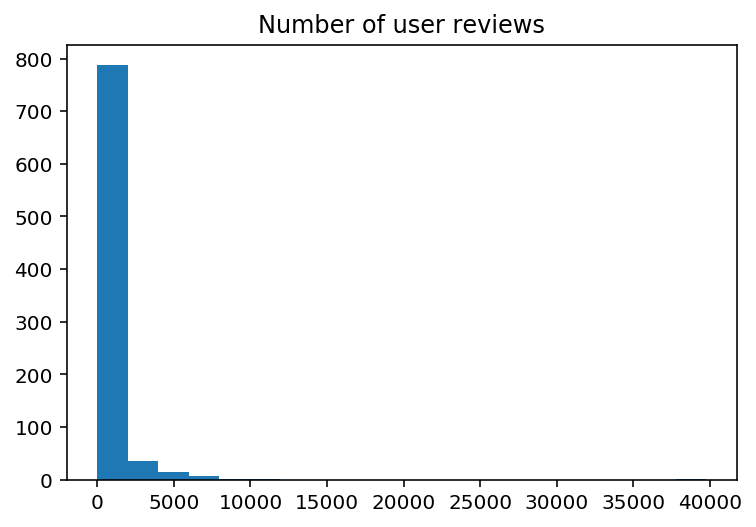

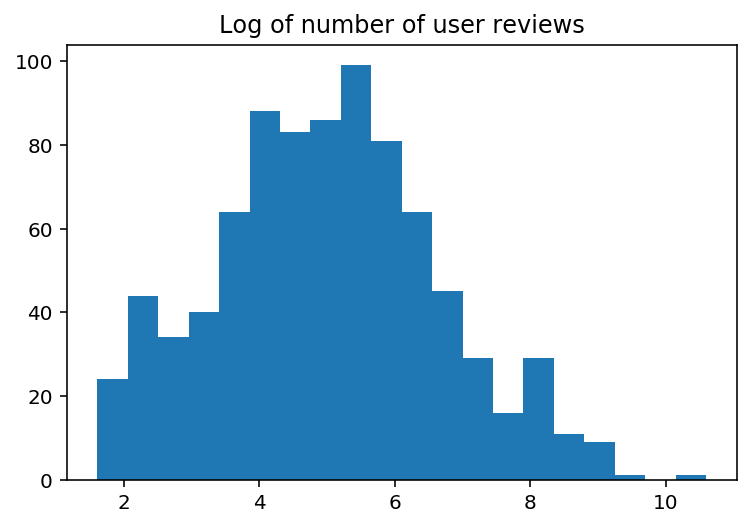

In [47]:
# visualise the number of user reviews
plt.hist(ratings.user_reviews, bins=20)
plt.title('Number of user reviews')
plt.show()

# visualise the log of the number of user reviews
plt.hist(np.log(ratings.user_reviews), bins=20)
plt.title('Log of number of user reviews')
plt.show()

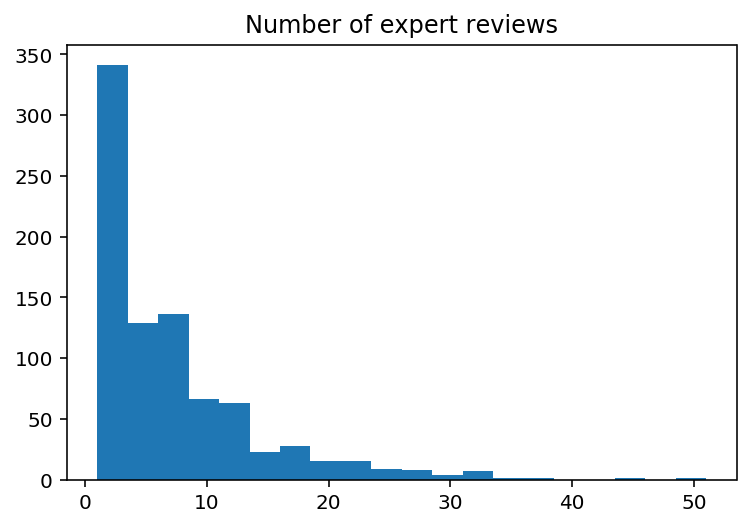

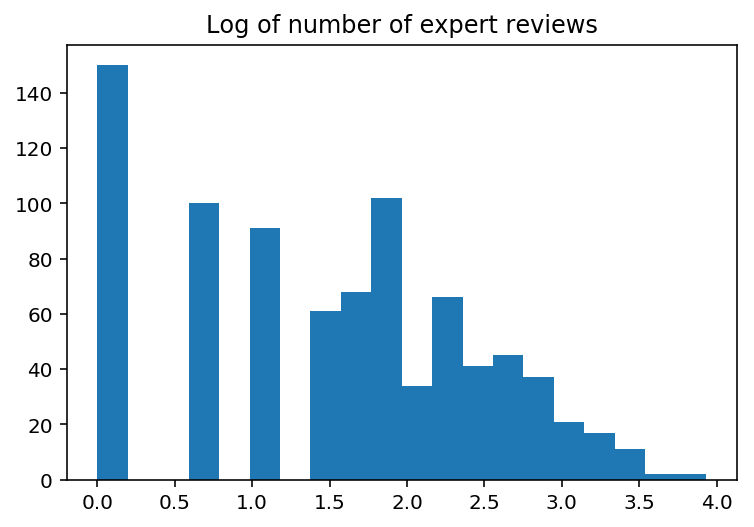

In [48]:
# visualise the number of expert reviews
plt.hist(ratings.expert_reviews, bins=20)
plt.title('Number of expert reviews')
plt.show()

# visualise the log of the number of expert reviews
plt.hist(np.log(ratings.expert_reviews), bins=20)
plt.title('Log of number of expert reviews')
plt.show()

In [49]:
# Score the number of reviews on a scale of between 0 to 1.
mm = MinMaxScaler()
ratings["user_popularity"] = mm.fit_transform(np.log(list(ratings.user_reviews)).reshape(-1,1))
ratings["expert_popularity"] = mm.fit_transform(np.log(list(ratings.expert_reviews)).reshape(-1,1))
ratings["average_popularity_sc"] = (ratings["user_popularity"] + ratings["expert_popularity"]) / 2

# Check ...
print('user_popularity, Min: {}, Max: {}'.format(round(ratings.user_popularity.min(),3), round(ratings.user_popularity.max(),3)))
print('expert_popularity, Min: {}, Max: {}'.format(round(ratings.expert_popularity.min(),3), round(ratings.expert_popularity.max(),3)))
ratings.head(10)

user_popularity, Min: 0.0, Max: 1.0
expert_popularity, Min: 0.0, Max: 1.0


,user_rating_sc,expert_rating_sc,average_rating_sc,user_reviews,expert_reviews,user_popularity,expert_popularity,average_popularity_sc
0,0.88,0.94,0.910,2249,27,0.680211,0.838246,0.759228
1,0.90,0.91,0.905,4358,17,0.753871,0.720585,0.737228
2,0.92,0.92,0.920,4091,8,0.746831,0.528874,0.637853
3,0.90,0.90,0.900,4158,1,0.748640,0.000000,0.374320
4,0.84,0.92,0.880,794,7,0.564279,0.494913,0.529596
5,0.88,0.92,0.900,1103,4,0.600880,0.352583,0.476731
6,0.96,0.90,0.930,16,13,0.129516,0.652356,0.390936
7,0.90,0.91,0.905,7191,13,0.809637,0.652356,0.730996
8,0.88,0.91,0.895,358,13,0.475583,0.652356,0.563970
9,0.88,0.88,0.880,1150,8,0.605526,0.528874,0.567200


In [50]:
# Save to pickle.
pickle.dump(ratings, open('ratings.pkl', 'wb'))